In [1]:
!pip install --upgrade seaborn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.2)


# Task

Understand the effects of various variables on the price of the most popular car ads placed online. Answer the questions of Sprint 3.

## The cars
The dataset has over 50k observations and 11 explanatory variables that are expected to impact its price such as age of the car, its condition, engine power in cylinders, its fuel type, its mileage, 4-wd and transmission as well as its color.  After preprocessing the data, I find the variables that affect our dependent variable of interest, price.


## Steps
1. Duplicate the original dataset
    -  Because the length of the data columns is going to change during the preprocessing, I will duplicate vehicle to a new dataframe called vehicle_temp.
    
2. Checking for duplicates
    - Ensure there are no duplicated observations in the data. 
    
2. Acquaint with the data:
    - Examine the variables one by one: 
        - Depending on its type, I use either bar charts or histograms.  The rule of thumb is histograms for continuous/numerical data and bars for categorical/object data.  Moreover, ince I will have to use some of these variables for pivot tables, I will also categorize most variables.  So each variable will have its original \<name> and its \<name_en> categorical version.
        - Remove outliers that are 3 standard deviations away from the mean.
        - Encode the data to facilitate statistical testing.  Where ever possible, keep/establish order in the categorization to make meaning of the regression coefficients.  For example, the condition variable will be reranked in order for the condition to improve as the encoding number increases.
      
3. Replace NaN:
    - Create pivot tables using variables without NaNs using mean/mode/median as aggfunc depending on the distribution of the variable in a violin plot.
    - Using a "replace_na" function to replace all NaNs.

4. Visualize each variable before and after to assess the effects of preprocessing on my data
    - Copy the newly preprocessed variables to a new dataframe called vehicle_final.  The date variable is not copied because it will not be used.  Instead I keep variable number of days listed.
    - Create a function to compare original variables with their preprocessed version. 
    
5. Compare each variable's effect on price
    - Because data is encoded, I run a data correlation matrix on all variables.  We know that the size and the direction of the relationship between two variables is given by the correlation coefficient.
    - I use a statistical regression model to assess each variable's weight and effect size on price. Larger coefficients don't necessarily identify more important predictor variables. When possible, establish the importance of each variable unit level increase on price.
    - Select the two types of cars with the greatest number of ads.
    
6. Answer the sprint questions
    - Take the two popular types and study whether their price depends on age, mileage, condition, transmission type, and color. For categorical variables (transmission type and color), plot box-and-whisker charts, and create scatterplots for the rest. When analyzing categorical variables, note that the categories must have at least 50 ads; otherwise, their parameters won't be valid for analysis.


In [2]:
!pip install tabulate

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.stem import WordNetLemmatizer
from pymystem3 import Mystem
from collections import Counter
m = Mystem()
wordnet_lemma = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from itertools import chain
from scipy import stats
from statsmodels.formula.api import ols
from tabulate import tabulate



 
try:
    vehicle = pd.read_csv("vehicles_us.csv")
except:
    vehicle = pd.read_csv('/datasets/vehicles_us.csv') 
vehicle.head()

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jovyan/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28


In [4]:
vehicle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 13 columns):
price           51525 non-null int64
model_year      47906 non-null float64
model           51525 non-null object
condition       51525 non-null object
cylinders       46265 non-null float64
fuel            51525 non-null object
odometer        43633 non-null float64
transmission    51525 non-null object
type            51525 non-null object
paint_color     42258 non-null object
is_4wd          25572 non-null float64
date_posted     51525 non-null object
days_listed     51525 non-null int64
dtypes: float64(4), int64(2), object(7)
memory usage: 5.1+ MB


We are starting with 51525 observations.   Our dataset has 4 floats and 2 integer variables and the rest are strings/objects. There are 4 variables with missing values.  All are floats.  I will start with paint color since it has the most consequential missing values.  

## 1 Create a copy dataframe from vehicle

In [5]:
vehicle_temp = vehicle.copy(deep=True)

In [6]:
vehicle_temp.head()

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28


# 1 Convert the date_posted into to_datetime

In [7]:
vehicle_temp.date_posted = pd.to_datetime(vehicle_temp.date_posted)

# 2 Check for Duplicates
  Let's check for duplicates.

In [8]:
vehicle_temp.duplicated().sum()

0

# 3 Acquaint with the data
I will start by exploring my variables and converting them to their intended use. I will change their names in order to create a new dataframe to compare before and after preprocessing values.

## Numeric data and its distribution.

In [9]:
vehicle_temp.describe()

,price,model_year,cylinders,odometer,is_4wd,days_listed
count,51525.000000,47906.000000,46265.000000,43633.000000,25572.0,51525.00000
mean,12132.464920,2009.750470,6.125235,115553.461738,1.0,39.55476
std,10040.803015,6.282065,1.660360,65094.611341,0.0,28.20427
min,1.000000,1908.000000,3.000000,0.000000,1.0,0.00000
25%,5000.000000,2006.000000,4.000000,70000.000000,1.0,19.00000
50%,9000.000000,2011.000000,6.000000,113000.000000,1.0,33.00000
75%,16839.000000,2014.000000,8.000000,155000.000000,1.0,53.00000
max,375000.000000,2019.000000,12.000000,990000.000000,1.0,271.00000


#### Price and Odometer have a very high standard deviation.  This means these two variables will make us lose a lot of observations when we remove their outliers. Care should be taken with price because often most expensive cars are the oldest and newest ones.  So, I will have to check for that by plotting price against model_year and odometer.  

### SUV variable

In [10]:
vehicle_temp.is_4wd.unique()

array([ 1., nan])

I assume that 1 is for 4wd and the rest are non-SUV. So, I will first duplicate this variable and then replace its NaN with 0.  I will then integerize it.

In [11]:
vehicle_temp['is_4wd_en'] = vehicle_temp.loc[:, 'is_4wd']

In [12]:
vehicle_temp.is_4wd_en.fillna(0, inplace = True)

In [13]:
vehicle_temp["is_4wd_en"] = vehicle_temp["is_4wd_en"].astype(int)

In [14]:
vehicle_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51525 entries, 0 to 51524
Data columns (total 14 columns):
price           51525 non-null int64
model_year      47906 non-null float64
model           51525 non-null object
condition       51525 non-null object
cylinders       46265 non-null float64
fuel            51525 non-null object
odometer        43633 non-null float64
transmission    51525 non-null object
type            51525 non-null object
paint_color     42258 non-null object
is_4wd          25572 non-null float64
date_posted     51525 non-null datetime64[ns]
days_listed     51525 non-null int64
is_4wd_en       51525 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(3), object(6)
memory usage: 5.5+ MB


## Visualize original object data distribution in bar chart with relative frequency

In [15]:
def show_bar_chart(dataframe: pd.core.frame.DataFrame, column_name: str):
    bar_data = dataframe[column_name].value_counts(normalize=True).head(10)

    bar_data.plot(
        kind='bar', figsize=(20, 3), rot=90, alpha=.5, fontsize=8
    )
    
    beautify_column_name = column_name[0].upper() + column_name[1:].replace('_', ' ')
    
    plt.title(f' Share of {beautify_column_name}', fontsize=18)
    plt.ylabel('Share', fontsize=12)
    plt.xlabel(beautify_column_name, fontsize=12)

    for i, (x, y) in enumerate(bar_data.to_dict().items()):
        plt.text(i-.15, y, s=str(round(y, 2)), fontsize=8)

    plt.show()


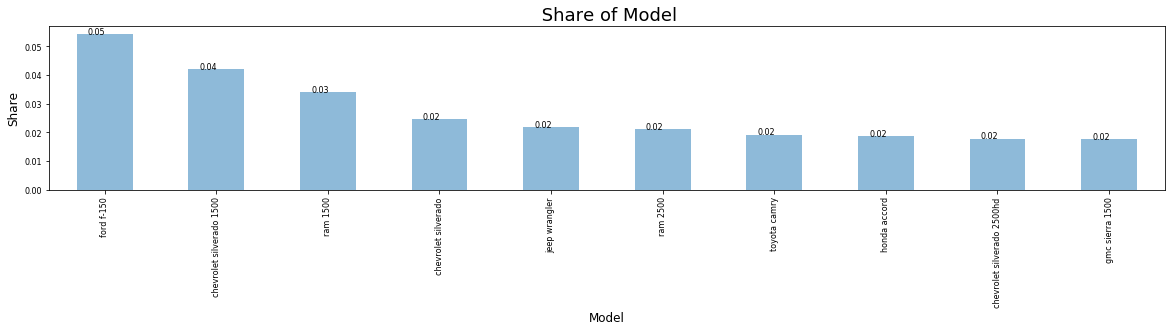

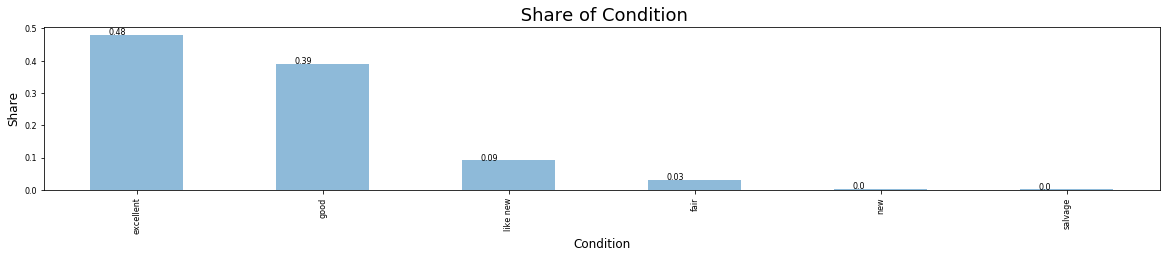

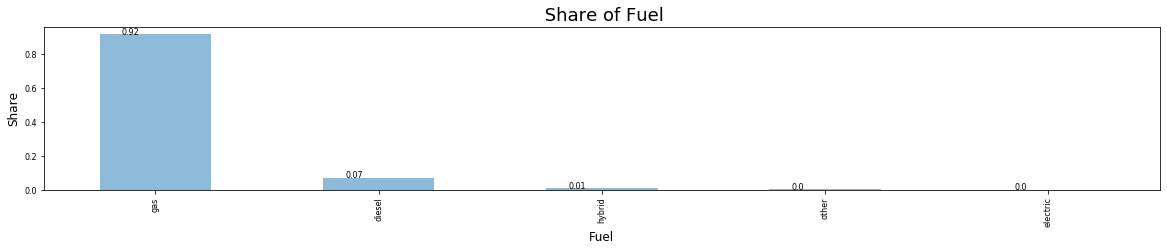

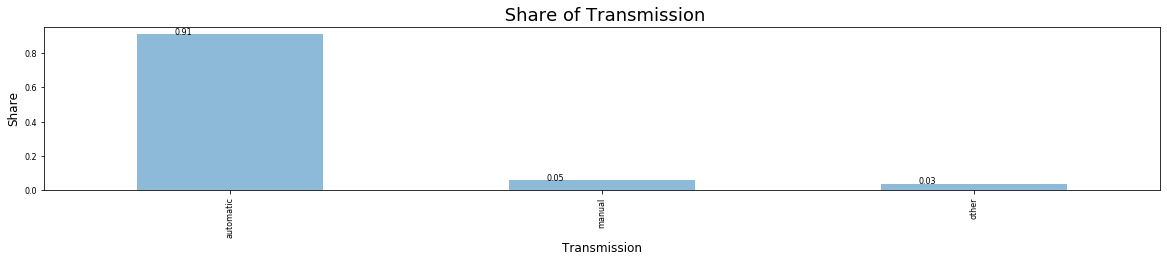

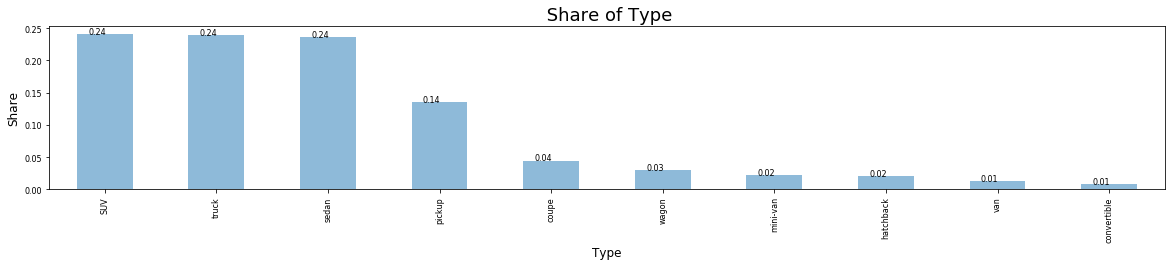

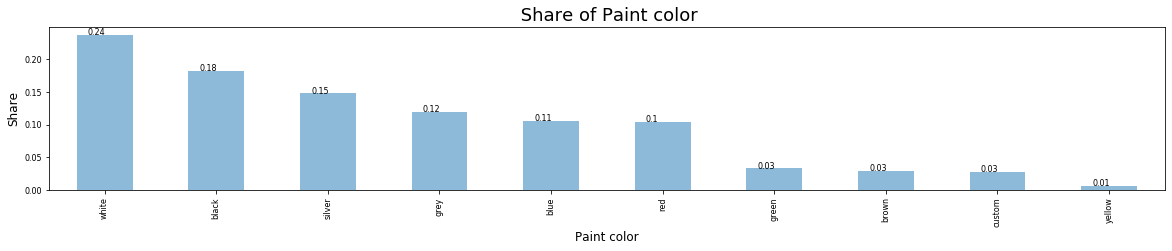

In [16]:
# plotting barplots for every column in our dataset

for column in vehicle_temp.columns:
    if vehicle_temp[column].dtype == 'object':
        show_bar_chart(vehicle_temp, column)

### Types SUVs (24.1%) , trucks (24%) and sedans (23.6%) of this dataset look like they have the most ads before preprocessing.  But still premature to decide if they will remain the highest ad cars after preprocessing.  Interestingly, most cars in this dataset seem to be in a good condition and above.  Unsurprisingly, they are mostly gas powered and automatic.   The car colors are also unsurprisingly within the range of common colors.

### Visualize original float data distribution in bar chart with relative frequency

In [17]:

def show_hist_loat_chart(dataframe: pd.core.frame.DataFrame, column_name: float):
    hist_data = dataframe[column_name]

    hist_data.plot(
        kind='hist', density=True, figsize=(10, 3), rot=90, alpha=.5, fontsize=8
    )
    
    beautify_column_name = column_name[0].upper() + column_name[1:].replace('_', ' ')
    
    plt.title(f'  {beautify_column_name}', fontsize=18)
    plt.ylabel('Share', fontsize=10)
    plt.xlabel(beautify_column_name, fontsize=10)

    plt.show()

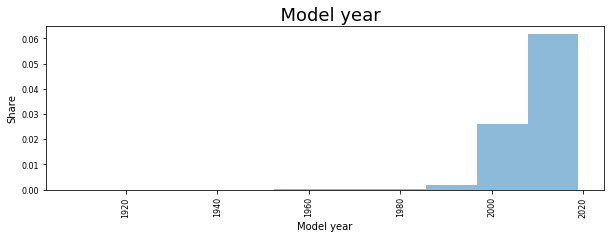

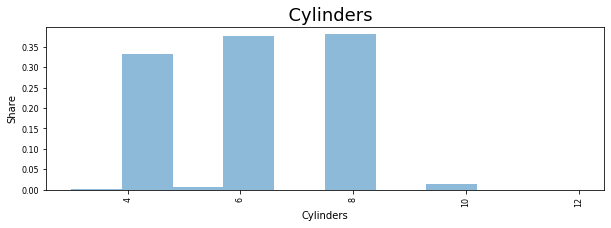

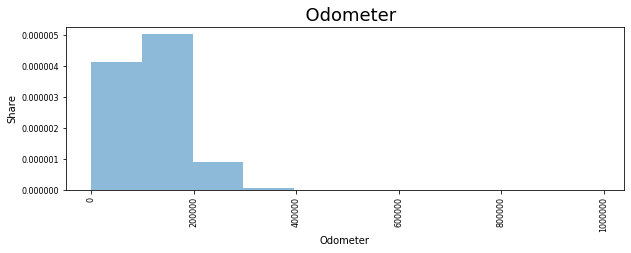

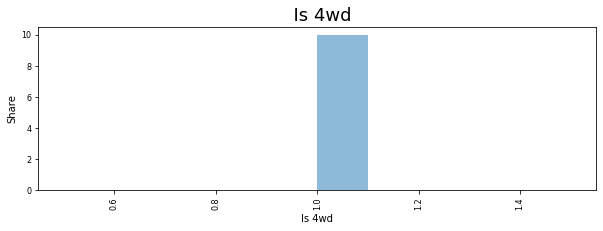

In [18]:
# plotting histplots for every column in our dataset

for column in vehicle_temp.columns:
    if vehicle_temp[column].dtype == 'float':
        show_hist_loat_chart(vehicle_temp, column)

### Visualize original integer data distribution in bar chart with relative frequency

In [19]:

def show_hist_int_chart(dataframe: pd.core.frame.DataFrame, column_name: int):
    hist_data = dataframe[column_name]

    hist_data.plot(
        kind='hist', density=True, figsize=(10, 3), rot=90, alpha=.5, fontsize=8
    )
    
    beautify_column_name = column_name[0].upper() + column_name[1:].replace('_', ' ')
    
    plt.title(f' Share of {beautify_column_name}', fontsize=18)
    plt.ylabel('Share', fontsize=10)
    plt.xlabel(beautify_column_name, fontsize=10)
    
    #fig, ax = plt.subplots()
 
   


    plt.show()



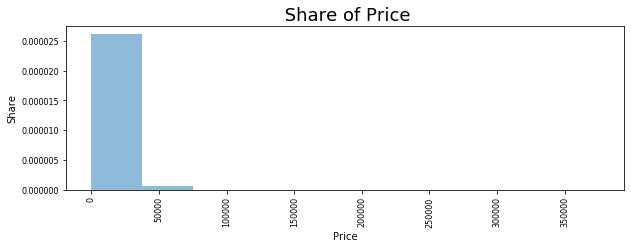

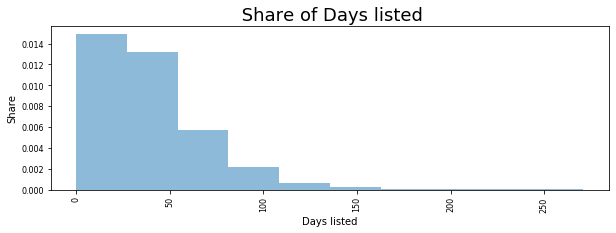

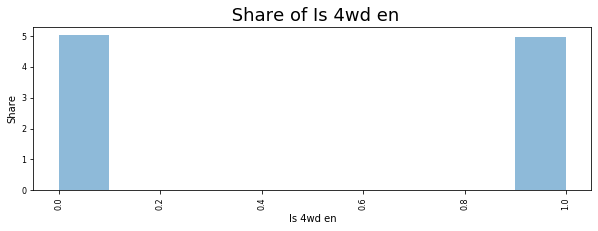

In [20]:
# plotting histplots for every column in our dataset

for column in vehicle_temp.columns:
    if vehicle_temp[column].dtype == 'int':
        show_hist_int_chart(vehicle_temp, column)

## Transmission encoding and type change into integer and rename.

In [21]:
vehicle_temp.transmission.unique()

array(['automatic', 'manual', 'other'], dtype=object)

In [22]:
def trans(val):
    if val == "automatic":
        return 0
    if val == "manual":
        return 1
    return 2   
vehicle_temp['transmission_en'] = vehicle_temp['transmission'].apply(trans)

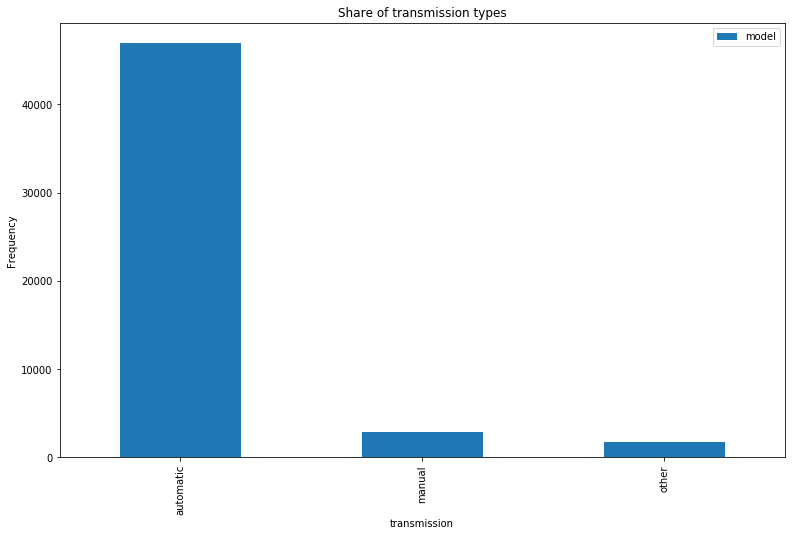

In [23]:
# Reviewer's code
vehicle_temp.groupby('transmission').agg({'model': 'count'}).plot(
    kind='bar', figsize=(13, 8)
)
plt.title("Share of transmission types")
plt.ylabel('Frequency')
plt.show()

## Condition variable encoding and type change and rename.

In [24]:
def cond(val):
    if val == "salvage":
        return 0
    if val == "fair":
        return 1
    if val == "good":
        return 2
    if val == "excellent":
        return 3
    if val == "like new":
        return 4
    if val == "new":
        return 5  
    return "other"
vehicle_temp['condition_en'] = vehicle_temp['condition'].apply(cond)

The values of this variable have been rearranged to some type of order so that condition improves as numbers increase.

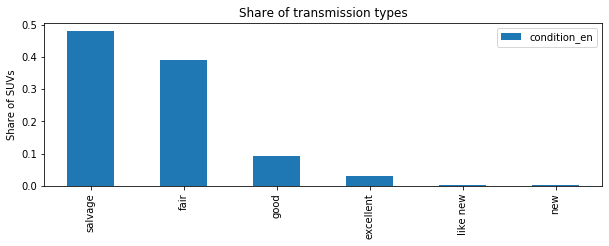

In [25]:
vehicle_temp.condition_en.value_counts(
    normalize=True).plot(kind='bar',  figsize = (10,3));
plt.title("Share of transmission types");
plt.legend()
plt.ylabel('Share of SUVs')
plt.xticks(ticks=[0,1,2,3,4,5], labels=['salvage', 'fair', "good", "excellent", "like new", "new"]);

## Fuel Type encoding and change of type and rename.

In [26]:
def fue(val):
    if val == "gas":
        return 0
    if val == "diesel":
        return 1
    if val == "hybrid":
        return 2
    if val == "electric":
        return 3
    if val == "other":
        return 4
    return "another_other"
vehicle_temp['fuel_en'] = vehicle_temp['fuel'].apply(fue)

The rule of thumb I use for this coding is that the most frequent value will be set at 0.

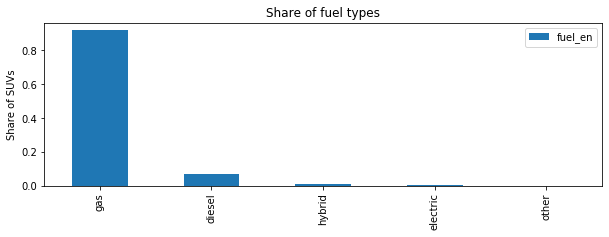

In [27]:
vehicle_temp.fuel_en.value_counts(
    normalize=True).plot(kind='bar',  figsize = (10,3));
plt.title("Share of fuel types");
plt.legend()
plt.ylabel('Share of SUVs')
plt.xticks(ticks=[0,1,2,3,4], labels=['gas', 'diesel', "hybrid", "electric", "other"]);

## Vehicle type encoding and change of variable type and rename.

In [28]:
vehicle_temp.type.unique()

array(['SUV', 'pickup', 'sedan', 'truck', 'coupe', 'van', 'convertible',
       'hatchback', 'wagon', 'mini-van', 'other', 'offroad', 'bus'],
      dtype=object)

In [29]:
def typ(val): 
    if val == "SUV":
        return 0
    if val == "truck":
        return 1
    if val == "sedan":
        return 2
    if val == "pickup":
        return 3
    if val == "coupe":
        return 4
    if val == "van":
        return 5
    if val == "convertible":
        return 6
    if val == "hatchback":
        return 7
    if val == "wagon":
        return 8
    if val == "mini-van":
        return 9
    if val == "offroad":
        return 10
    if val == "bus":
        return 11
    if val == "other":
        return 12
    return "another_other"
vehicle_temp['type_en'] = vehicle_temp['type'].apply(typ)

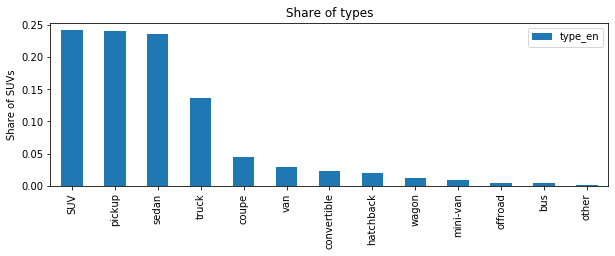

In [30]:
vehicle_temp.type_en.value_counts(
    normalize=True).plot(kind='bar',  figsize = (10,3));
plt.title("Share of types");
plt.legend()
plt.ylabel('Share of SUVs')
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9,10,11,12], labels=[
    'SUV', 'pickup', "sedan", "truck", "coupe", "van", "convertible", "hatchback", "wagon", "mini-van", "offroad", "bus", "other" ]);

In [31]:
vehicle_temp.model.unique()

array(['bmw x5', 'ford f-150', 'hyundai sonata', 'chrysler 200',
       'chrysler 300', 'toyota camry', 'honda pilot', 'kia sorento',
       'chevrolet silverado 1500', 'honda accord', 'ram 1500',
       'gmc yukon', 'jeep cherokee', 'chevrolet traverse',
       'hyundai elantra', 'chevrolet tahoe', 'toyota rav4',
       'chevrolet silverado', 'jeep wrangler', 'chevrolet malibu',
       'ford fusion se', 'chevrolet impala', 'chevrolet corvette',
       'jeep liberty', 'toyota camry le', 'nissan altima',
       'subaru outback', 'toyota highlander', 'dodge charger',
       'toyota tacoma', 'chevrolet equinox', 'nissan rogue',
       'mercedes-benz benze sprinter 2500', 'honda cr-v',
       'jeep grand cherokee', 'toyota 4runner', 'ford focus',
       'honda civic', 'kia soul', 'chevrolet colorado',
       'ford f150 supercrew cab xlt', 'chevrolet camaro lt coupe 2d',
       'chevrolet cruze', 'ford mustang', 'chevrolet silverado 3500hd',
       'nissan frontier crew cab sv', 'subaru imp

In [32]:
x = vehicle_temp.model.str.split()
c = Counter(chain(*[x for x in x]))

c


Counter({'bmw': 267,
         'x5': 267,
         'ford': 12672,
         'f-150': 2796,
         'hyundai': 1173,
         'sonata': 477,
         'chrysler': 838,
         '200': 243,
         '300': 316,
         'toyota': 5445,
         'camry': 1306,
         'honda': 3485,
         'pilot': 302,
         'kia': 585,
         'sorento': 236,
         'chevrolet': 10611,
         'silverado': 4903,
         '1500': 5130,
         'accord': 964,
         'ram': 3316,
         'gmc': 2378,
         'yukon': 331,
         'jeep': 3281,
         'cherokee': 1355,
         'traverse': 329,
         'elantra': 423,
         'tahoe': 713,
         'rav4': 461,
         'wrangler': 1571,
         'malibu': 617,
         'fusion': 853,
         'se': 685,
         'impala': 674,
         'corvette': 499,
         'liberty': 355,
         'le': 316,
         'nissan': 3208,
         'altima': 813,
         'subaru': 1272,
         'outback': 538,
         'highlander': 334,
         'dodge':

Based on frequencies and knowledge of what car exist in the US market, I compile the list below.  Is there a better way for doing this.  Also this for loop is too slow, can you recommend a better way for doing it?

In [33]:

list1 = ["bmw", "ford", "hyundai", "chrysler", "toyota", "honda", "kia", "chevrolet", "ram", "gmc", "jeep", 
"cherokee", "nissan", "subaru", "benz", "cadillac", "volkswagen", "dodge", "buick", "acura"]

def replace_string(row):        
    for i in list1:
        if i in row["model"]:
            return i
    return row["model"]      

vehicle_temp['model_temp'] = vehicle_temp.apply(replace_string, axis=1)
vehicle_temp['model_temp'].unique()

array(['bmw', 'ford', 'hyundai', 'chrysler', 'toyota', 'honda', 'kia',
       'chevrolet', 'ram', 'gmc', 'jeep', 'nissan', 'subaru', 'dodge',
       'benz', 'acura', 'cadillac', 'volkswagen', 'buick'], dtype=object)

In [34]:
def mode(val):
    
    if val == "acura":
        return 0
    if val == "benz":
        return 1
    if val == "bmw":
        return 2
    if val == "buick":
        return 3
    if val == "cadillac":
        return 4
    if val == "chevrolet":
        return 5
    if val == "chrysler":
        return 6
    if val == "dodge":
        return 7
    if val == "ford":
        return 8
    if val == "gmc":
        return 9
    if val == "honda":
        return 10
    if val == "hyundai":
        return 11
    if val == "jeep":
        return 12
    if val == "kia":
        return 13
    if val == "nissan":
        return 14
    if val == "subaru":
        return 15
    if val == "toyota":
        return 16
    if val == "volkswagen":
        return 17
    if val == "ram":
        return 18
    return 'other'

vehicle_temp['model_en']=vehicle_temp['model_temp'].apply(mode)

### Handling price, the dependent variable.  As I mentioned earlier, I will categorize price to use it in pivot tables, but as a dependent variable, I will keep it continuous.  In order to remove the outliers, I attempt to visualize this variables with other directly related variable such as model_year and odometer.  The reason for this decision is that if a 1900 model car is selling for 300k and it is in an excellent condition, then maybe it is worth keeping in the dataset.  Moreover if a new car has 200k miles, it will be cheaper than a regular car.

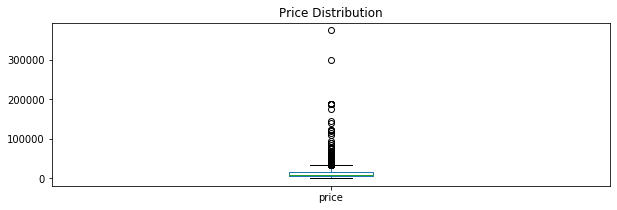

In [35]:
vehicle_temp.price.plot(kind='box', figsize = (10,3), title = "Price Distribution");

Too many outliers in our dependent variable of interest.

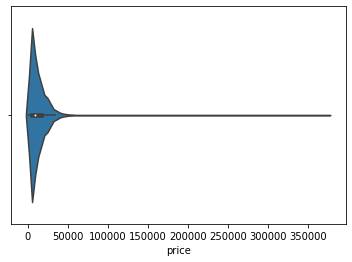

In [36]:
sns.violinplot(x="price", data=vehicle_temp);

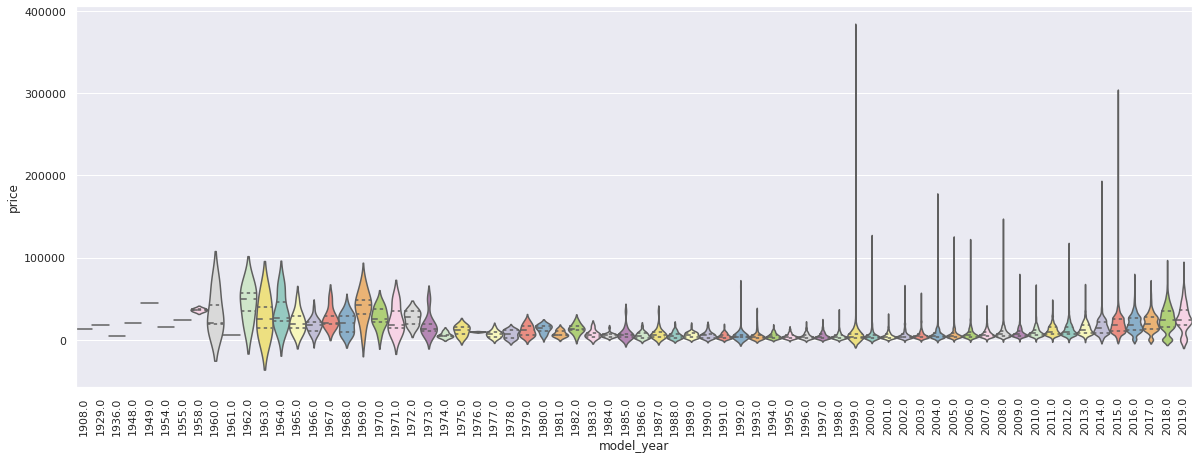

In [37]:
sns.set(rc={'figure.figsize':(20,7)})
ax = sns.violinplot(x="model_year", y="price", split=True, width=1, scale="width", inner="quartile", palette="Set3",  data=vehicle_temp)
ax.tick_params(axis='x', labelrotation = 90)
plt.show()

Price seems to have more variation/outliers for cars from 1999 to 2015.

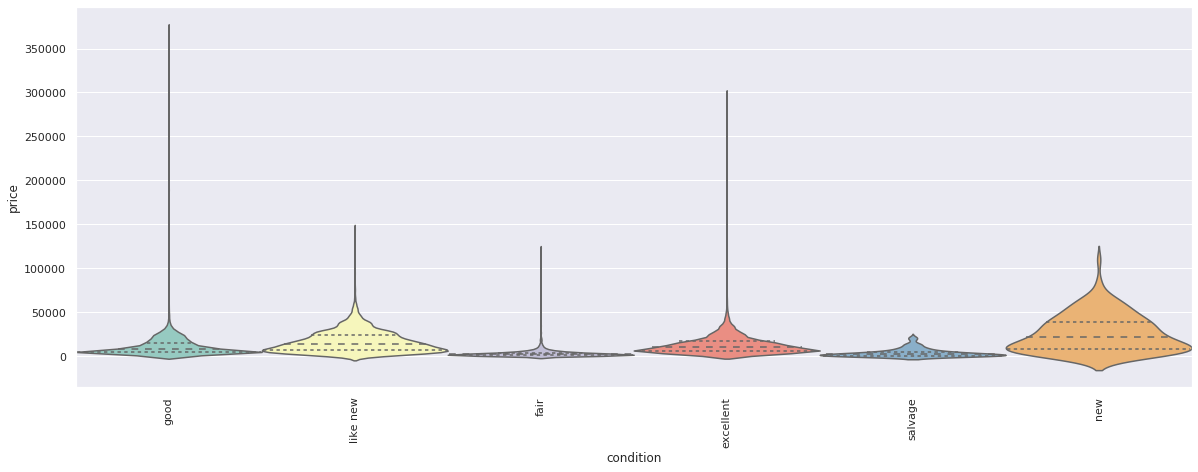

In [38]:
sns.set(rc={'figure.figsize':(20,7)})
ax = sns.violinplot(x="condition" , y="price", split=True, width=1, scale="width", palette="Set3",inner="quartile", data=vehicle_temp)
ax.tick_params(axis='x', labelrotation = 90)
plt.show()

Price seems to have more price outliers for good and excellent condition cars.  I will clean the price variable for outliers above the 3 standard deviation prices and rerun these same charts.

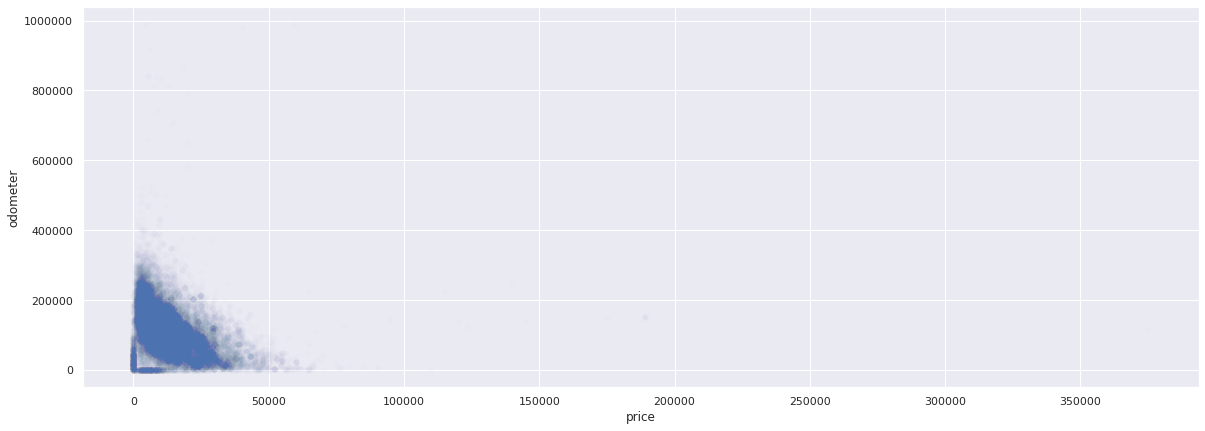

In [39]:
# Reviewer's code
sns.scatterplot(data=vehicle_temp, x="price", y="odometer", alpha=0.01)

Unfortunately, odometer has lots of NaNs, so we should proceed with preprocessing price before odometer.

In [40]:
vehicle_temp.shape

(51525, 20)

In [41]:
q_low = vehicle_temp["price"].quantile(0.01)
q_hi  = vehicle_temp["price"].quantile(0.99)

vehicle_temp  = vehicle_temp[(vehicle_temp["price"] < q_hi) & (vehicle_temp["price"] > q_low)] 
vehicle_temp.shape

(50207, 20)

Lost 1318 observations by dropping observations whose price is outside 3 standard deviations from the mean.

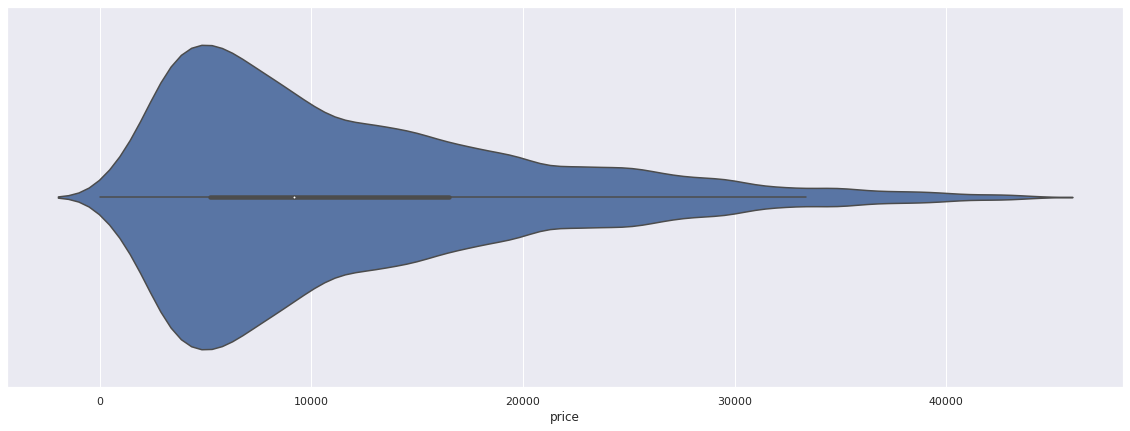

In [42]:
sns.violinplot(x="price", data=vehicle_temp);

## Categorize the price variable for use in the pivot tables.

In [43]:
vehicle_temp.price.quantile([.1, .2, .3, .4, .5,.6, .7, .8,.9])

0.1     3200.0
0.2     4575.0
0.3     5995.0
0.4     7500.0
0.5     9199.0
0.6    11900.0
0.7    14900.0
0.8    18600.0
0.9    24990.0
Name: price, dtype: float64

In [44]:
def pri(dollar):
    
    if dollar <= 3000:
        return 0
    if dollar <= 4500:
        return 1
    if dollar <= 6000:
        return 2
    if dollar <= 7500:
        return 3
    if dollar <= 9000:
        return 4
    if dollar <= 12000:
        return 5
    if dollar <= 15000:
        return 6
    if dollar <= 18500:
        return 7
    if dollar <= 25000:
        return 8
    return 9


vehicle_temp['price_cat'] = vehicle_temp['price'].apply(pri)
print(vehicle_temp['price_cat'].value_counts())

2    6064
5    5939
8    5396
1    5119
6    5078
0    4908
9    4701
4    4638
3    4357
7    4007
Name: price_cat, dtype: int64


# 4  Tackling missing values

#### Clean up the temp dataframe

In [45]:
vehicle_temp.drop([ "is_4wd", "condition", "fuel", "transmission", "type", "model" ], axis = 1, inplace = True)

In [46]:
vehicle_temp.isna().sum()

price                 0
model_year         3537
cylinders          5136
odometer           7703
paint_color        9043
date_posted           0
days_listed           0
is_4wd_en             0
transmission_en       0
condition_en          0
fuel_en               0
type_en               0
model_temp            0
model_en              0
price_cat             0
dtype: int64

To understand the severity of the problem, we can calculate the relative percentage of the mission values per variable.

In [47]:
vehicle_temp.isna().sum() / vehicle.shape[0] * 100

price               0.000000
model_year          6.864629
cylinders           9.967977
odometer           14.950024
paint_color        17.550704
date_posted         0.000000
days_listed         0.000000
is_4wd_en           0.000000
transmission_en     0.000000
condition_en        0.000000
fuel_en             0.000000
type_en             0.000000
model_temp          0.000000
model_en            0.000000
price_cat           0.000000
dtype: float64

I will start filling NaNs in this order: paint_color, odometer, cylinder and then model year.  

##  Paint

#### Start with paint_color since it has the most missing values. There is a tradeoff here.  Either I remove all the row where paint is NaN, or a keep them and live with the NaN.  A third choice is to dichotomize color into common and uncommon colors.  This way, I can use the mode aggfunc to fill in the nans.  I adopt this third choice.

In [48]:
vehicle_temp['paint_color'].unique()

array([nan, 'white', 'red', 'black', 'blue', 'grey', 'silver', 'custom',
       'orange', 'yellow', 'brown', 'green', 'purple'], dtype=object)

In [49]:
vehicle_temp['paint_color'].value_counts().sort_index(ascending = False)

yellow     253
white     9714
silver    6142
red       4337
purple     102
orange     222
grey      4944
green     1383
custom    1078
brown     1211
blue      4385
black     7393
Name: paint_color, dtype: int64

In [50]:
def color(val):
    if val in ["white", "silver", "red", "grey", "green", "brown", "blue", "black"]:
        return 0
    if val in ["yellow", "purple", "orange", "custom"]:
        return 1
vehicle_temp['color_en_na'] = vehicle_temp['paint_color'].apply(color)

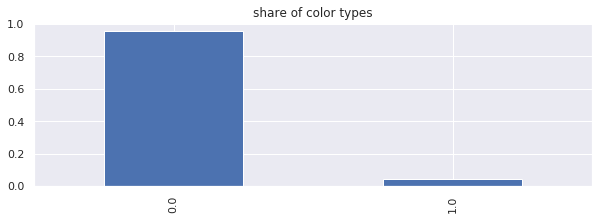

In [51]:
vehicle_temp.color_en_na.value_counts(
    normalize=True).plot(kind='bar', figsize = (10,3), title = "share of color types");


Use mode as aggfun for this weird variable since we cannot predict color.

In [52]:
pivot_color = vehicle_temp.pivot_table(index =   "transmission_en" , 
                   columns = "price_cat" , values = 'color_en_na', 
                   aggfunc = lambda x: x.mode().iat[0])
pivot_color

price_cat,0,1,2,3,4,5,6,7,8,9
transmission_en,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
def replace_na(row): 
    price = row['price_cat']
    transmission = row['transmission_en']
    if pd.isnull(row['color_en_na']):
        return pivot_color[price][transmission]
    else: 
        return row['color_en_na']


vehicle_temp["color_en"] = vehicle_temp.apply(replace_na, axis=1)
vehicle

,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51520,9249,2013.0,nissan maxima,like new,6.0,gas,88136.0,automatic,sedan,black,NaN,2018-10-03,37
51521,2700,2002.0,honda civic,salvage,4.0,gas,181500.0,automatic,sedan,white,NaN,2018-11-14,22
51522,3950,2009.0,hyundai sonata,excellent,4.0,gas,128000.0,automatic,sedan,blue,NaN,2018-11-15,32
51523,7455,2013.0,toyota corolla,good,4.0,gas,139573.0,automatic,sedan,black,NaN,2018-07-02,71


In [54]:
vehicle_temp["color_en"] = vehicle_temp["color_en"].astype(int)

In [55]:
vehicle_temp.shape

(50207, 17)

## Now odometer

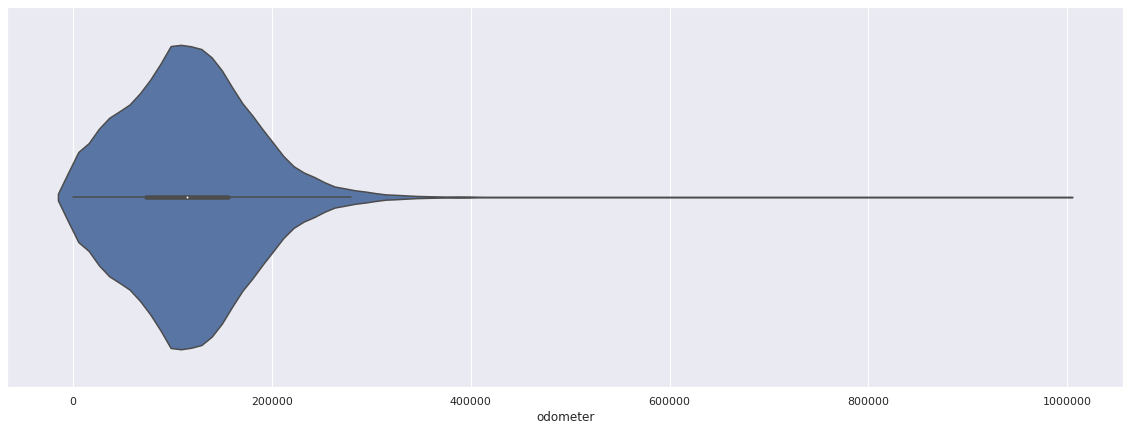

In [56]:
sns.violinplot(x="odometer", data=vehicle_temp);

In [57]:
q_low = vehicle_temp["odometer"].quantile(0.01)
q_hi  = vehicle_temp["odometer"].quantile(0.99)

vehicle_temp = vehicle_temp[(vehicle["odometer"] < q_hi) & (vehicle_temp["odometer"] > q_low)]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [58]:
vehicle_temp.shape

(41650, 17)

Removing the outliers of odometer cost us 8557 observations. This is huge, but necessary.  As we have seen in the scatterplot above as well as the .info() results, odometer was problematic.

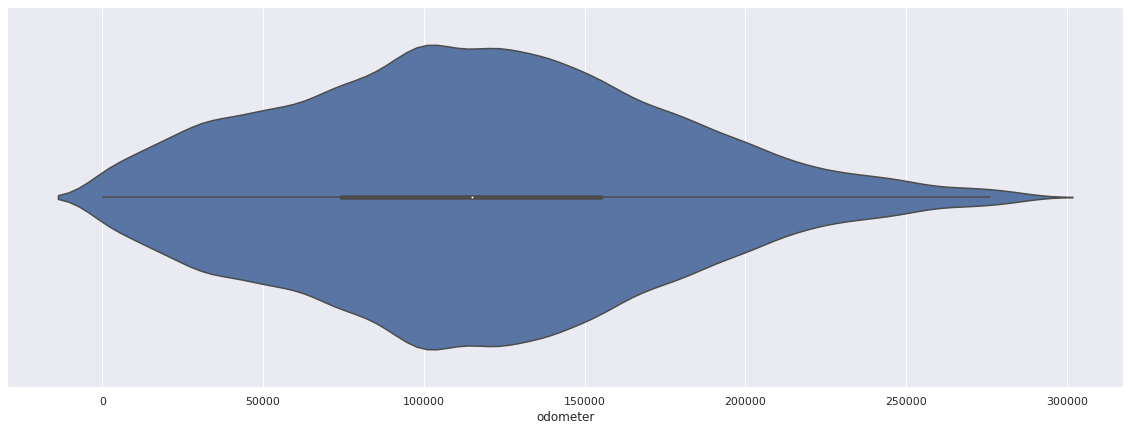

In [59]:
sns.violinplot(x="odometer", data=vehicle_temp);

In [60]:
#vehicle['odometer'].quantile([.15, .3, .45, .6, .75, .9])
vehicle['odometer'].quantile([.1, .2, .3, .4, .5, .6, .7, .8, .9])

0.1     31860.8
0.2     58143.2
0.3     80000.0
0.4     97896.2
0.5    113000.0
0.6    129000.0
0.7    145624.0
0.8    166000.0
0.9    196000.0
Name: odometer, dtype: float64

In [61]:
def odo(miles):
    
    if miles <= 30000:
        return 0
    if miles <= 60000:
        return 1
    if miles <= 80000:
        return 2
    if miles <= 100000:
        return 3
    if miles <= 115000:
        return 4
    if miles <= 130000:
        return 5
    if miles <= 145000:
        return 6
    if miles <= 165000:
        return 7
    if miles > 195000:
        return 8
    return 9
    

vehicle_temp['odo_en_na'] = vehicle_temp['odometer'].apply(odo)
print(vehicle_temp['odo_en_na'].value_counts())

3    5050
1    4685
9    4401
7    4313
5    4230
4    4186
8    4009
2    3951
6    3812
0    3013
Name: odo_en_na, dtype: int64


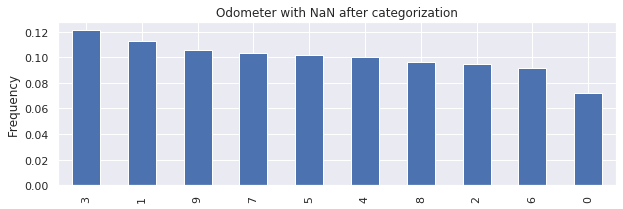

In [62]:
vehicle_temp.odo_en_na.value_counts(
    normalize=True).plot(kind='bar',  figsize = (10,3));
plt.title("Odometer with NaN after categorization")
plt.ylabel('Frequency')
plt.show()

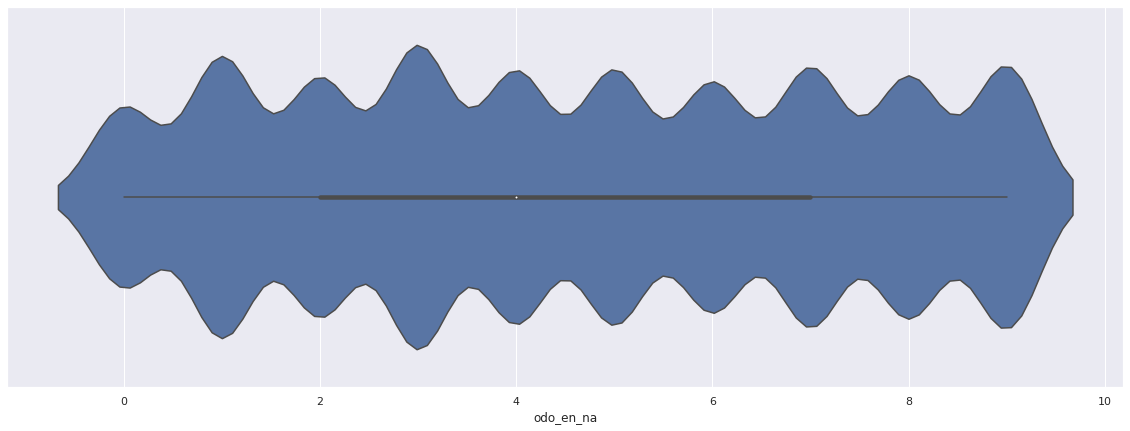

In [63]:
sns.violinplot(x="odo_en_na", data=vehicle_temp);

Either mean or median would do

In [64]:
pivot_odo = vehicle_temp.pivot_table(index =    ["price_cat", "model_en"] , 
                   columns = 'condition_en', values = 'odo_en_na', 
                   aggfunc = "median")
pivot_odo

condition_en          0    1    2    3    4    5
price_cat model_en                              
0         0         NaN  8.0  8.0  8.0  7.5  NaN
          2         NaN  5.0  7.0  3.0  NaN  NaN
          3         NaN  9.0  6.5  6.5  3.0  NaN
          4         NaN  8.0  8.5  9.0  NaN  NaN
          5         6.0  8.0  8.0  6.0  1.5  NaN
...                 ...  ...  ...  ...  ...  ...
9         13        NaN  NaN  NaN  0.0  NaN  NaN
          14        NaN  NaN  0.0  0.0  0.0  NaN
          15        NaN  NaN  NaN  0.0  0.5  NaN
          16        NaN  NaN  1.0  1.0  0.0  0.0
          18        NaN  NaN  3.0  2.0  1.0  1.0

[175 rows x 6 columns]

In [65]:
def replace_na(row): 
    condition = row["condition_en"] 
    model = row["model_en"] 
    price = row['price_cat']
    
    if pd.isnull(row['odo_en_na']):
        return pivot_odo[condition][price][model]
    else: 
        return row['odo_en_na']


vehicle_temp["odo_en"] = vehicle_temp.apply(replace_na, axis=1)
vehicle_temp.head()

,price,model_year,cylinders,odometer,paint_color,date_posted,days_listed,is_4wd_en,transmission_en,condition_en,fuel_en,type_en,model_temp,model_en,price_cat,color_en_na,color_en,odo_en_na,odo_en
0,9400,2011.0,6.0,145000.0,NaN,2018-06-23,19,1,0,2,0,0,bmw,2,5,NaN,0,6,6
1,25500,NaN,6.0,88705.0,white,2018-10-19,50,1,0,2,0,3,ford,8,9,0.0,0,3,3
2,5500,2013.0,4.0,110000.0,red,2019-02-07,79,0,0,4,0,2,hyundai,11,2,0.0,0,4,4
4,14900,2017.0,4.0,80903.0,black,2019-04-02,28,0,0,3,0,2,chrysler,6,6,0.0,0,3,3
5,14990,2014.0,6.0,57954.0,black,2018-06-20,15,1,0,3,0,2,chrysler,6,6,0.0,0,1,1


In [66]:
vehicle_temp.shape

(41650, 19)

## Now cylinders

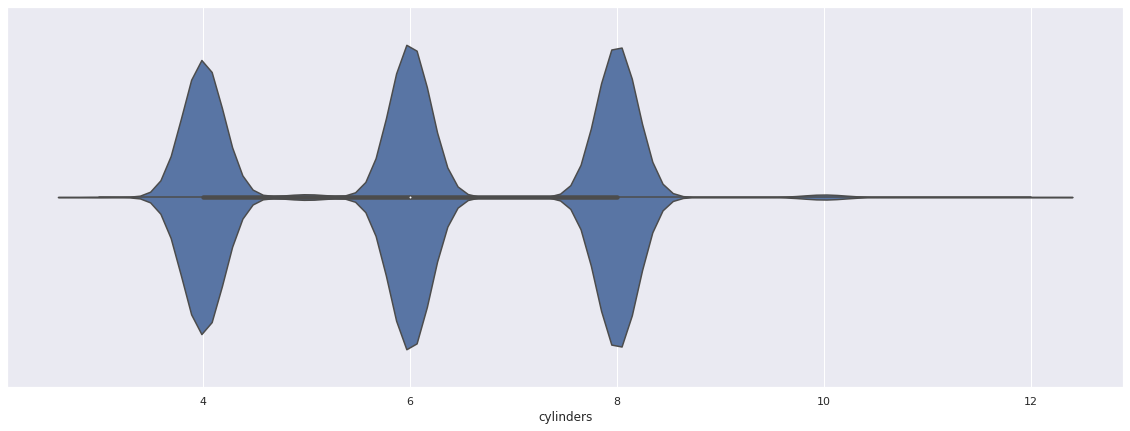

In [67]:
sns.violinplot(x="cylinders", data=vehicle_temp);

I guess I can remove 12 cylinders.

In [68]:
vehicle_temp  = vehicle_temp[(vehicle_temp["cylinders"] <= 10) ] 

In [69]:
vehicle_temp.shape

(37390, 19)

Cleaning the cylinder variable cost us another 4260 observations.

In [70]:
def cyl(val):
    
    if val <= 3:
        return 0
    if val <=4:
        return 1
    if val <=5:
        return 2
    if val <=6:
        return 3
    if val <=8:
        return 4
    if val <=10:
        return 5
    return 6
    
vehicle_temp['cylinders_en_na'] = vehicle_temp['cylinders'].apply(cyl)
print(vehicle_temp['cylinders_en_na'].value_counts())

3    12812
4    12713
1    11395
2      233
5      209
0       28
Name: cylinders_en_na, dtype: int64


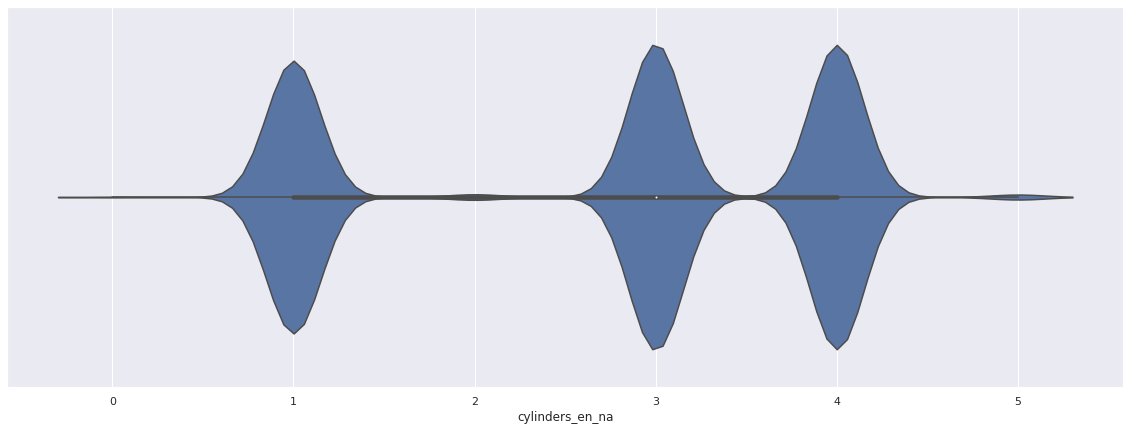

In [71]:
sns.violinplot(x="cylinders_en_na", data=vehicle_temp);

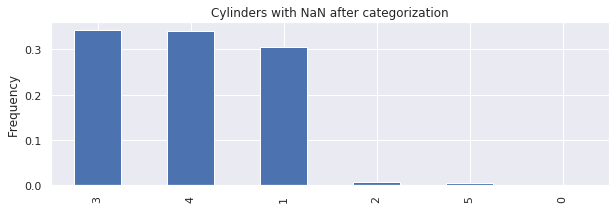

In [72]:
vehicle_temp.cylinders_en_na.value_counts(
    normalize=True).plot(kind='bar',  figsize = (10,3));
plt.title("Cylinders with NaN after categorization")
plt.ylabel('Frequency')
plt.show()

#### Given the shape of the distribution, I will use median.  I believe that model, price, odometer, and model should help replace Nan

In [73]:
pivot_cylinder = vehicle_temp.pivot_table(index =   ["odo_en" , "price_cat"],
                   columns = 'model_en', values = 'cylinders_en_na', 
                   aggfunc = "median")
pivot_cylinder

model_en           0    2    3    4    5    6    7    8    9    10   11   12  \
odo_en price_cat                                                               
0      0          3.0  NaN  NaN  NaN  4.0  NaN  3.0  3.0  4.0  1.0  3.0  3.0   
       1          3.0  NaN  NaN  NaN  3.0  NaN  NaN  3.0  NaN  1.0  1.0  3.0   
       2          3.0  3.0  NaN  NaN  4.0  2.0  4.0  3.0  3.5  1.0  2.5  2.0   
       3          NaN  NaN  NaN  NaN  1.0  3.0  NaN  3.5  3.0  1.0  1.0  1.0   
       4          3.0  NaN  NaN  4.0  1.0  1.0  NaN  1.0  4.0  1.0  1.0  3.0   
...               ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
9      5          NaN  3.0  3.0  4.0  4.0  3.0  4.0  4.0  4.0  2.0  NaN  3.0   
       6          NaN  NaN  NaN  4.0  4.0  NaN  NaN  4.0  4.0  NaN  NaN  3.0   
       7          NaN  NaN  NaN  4.0  4.0  NaN  NaN  4.0  4.0  NaN  NaN  3.0   
       8          NaN  NaN  NaN  NaN  4.0  NaN  NaN  4.0  4.0  NaN  NaN  NaN   
       9          NaN  NaN  NaN  NaN  4.0  NaN  NaN  4.0  4.0  NaN  NaN  NaN   

model_en           13   14   15   16   17   18  
odo_en price_cat                                
0      0          3.0  1.0  1.0  1.0  1.0  2.0  
       1          NaN  1.0  1.0  1.0  NaN  3.0  
       2          1.0  1.0  1.0  1.0  2.0  4.0  
       3          NaN  1.0  1.0  1.0  1.0  4.0  
       4          1.0  1.0  1.0  3.0  1.0  NaN  
...               ...  ...  ...  ...  ...  ...  
9      5          NaN  3.0  1.0  3.0  NaN  4.0  
       6          NaN  NaN  NaN  3.0  NaN  3.5  
       7          NaN  NaN  NaN  3.5  NaN  3.0  
       8          NaN  NaN  NaN  3.0  NaN  3.0  
       9          NaN  NaN  NaN  NaN  NaN  3.0  

[100 rows x 18 columns]

In [74]:
def replace_na(row): 
    #condition = row["condition_en"] 
    price = row['price_cat']
    model = row["model_en"] 
    odo = row['odo_en']
    if pd.isnull(row['cylinders_en_na']):
        return pivot_cylinder[model][price][odo]
    else: 
        return row['cylinders_en_na']


vehicle_temp["cylinders_en"] = vehicle_temp.apply(replace_na, axis=1)
vehicle_temp

,price,model_year,cylinders,odometer,paint_color,date_posted,days_listed,is_4wd_en,transmission_en,condition_en,...,type_en,model_temp,model_en,price_cat,color_en_na,color_en,odo_en_na,odo_en,cylinders_en_na,cylinders_en
0,9400,2011.0,6.0,145000.0,NaN,2018-06-23,19,1,0,2,...,0,bmw,2,5,NaN,0,6,6,3,3
1,25500,NaN,6.0,88705.0,white,2018-10-19,50,1,0,2,...,3,ford,8,9,0.0,0,3,3,3,3
2,5500,2013.0,4.0,110000.0,red,2019-02-07,79,0,0,4,...,2,hyundai,11,2,0.0,0,4,4,1,1
4,14900,2017.0,4.0,80903.0,black,2019-04-02,28,0,0,3,...,2,chrysler,6,6,0.0,0,3,3,1,1
5,14990,2014.0,6.0,57954.0,black,2018-06-20,15,1,0,3,...,2,chrysler,6,6,0.0,0,1,1,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51518,3750,2005.0,6.0,110200.0,silver,2018-08-10,63,0,0,3,...,2,ford,8,1,0.0,0,4,4,3,3
51520,9249,2013.0,6.0,88136.0,black,2018-10-03,37,0,0,4,...,2,nissan,14,5,0.0,0,3,3,3,3
51521,2700,2002.0,4.0,181500.0,white,2018-11-14,22,0,0,0,...,2,honda,10,0,0.0,0,9,9,1,1
51522,3950,2009.0,4.0,128000.0,blue,2018-11-15,32,0,0,3,...,2,hyundai,11,1,0.0,0,5,5,1,1


In [75]:
vehicle_temp.shape

(37390, 21)

#### Then, model_year

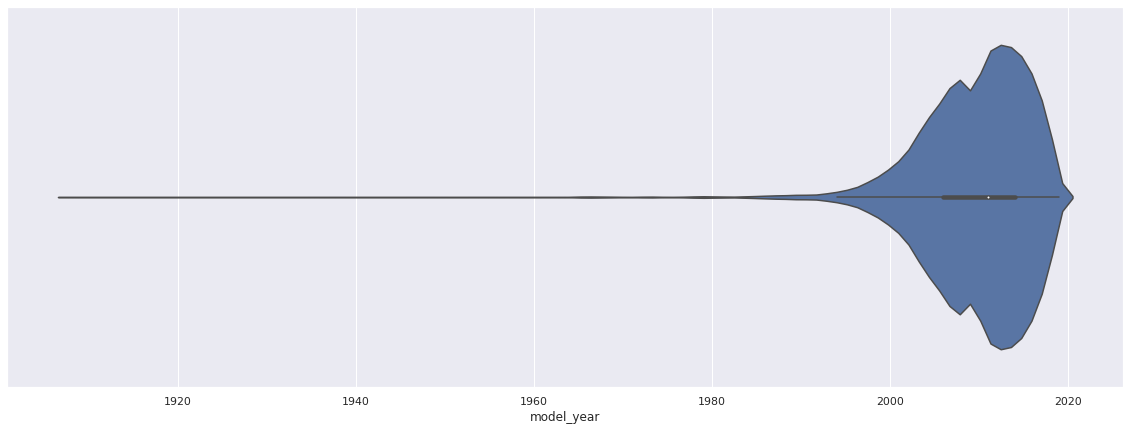

In [76]:
sns.violinplot(x="model_year", data=vehicle_temp)

In [77]:
q_low = vehicle_temp["model_year"].quantile(0.01)
q_hi  = vehicle_temp["model_year"].quantile(0.99)

vehicle_temp = vehicle_temp[(vehicle["model_year"] < q_hi) & (vehicle_temp["model_year"] > q_low)]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [78]:
vehicle_temp.shape

(32862, 21)

This removing of the outliers made us loose 4528 observations.

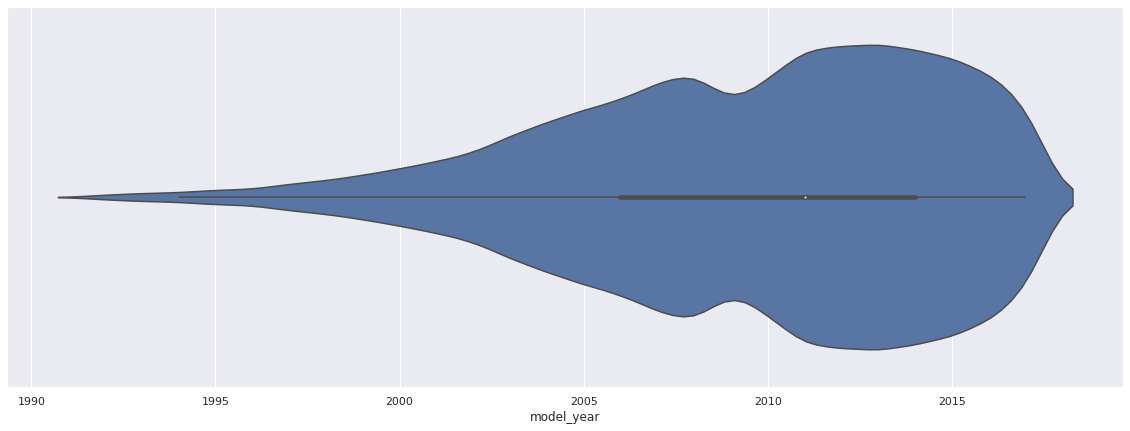

In [79]:
sns.violinplot(x="model_year", data=vehicle_temp)

In [80]:
vehicle_temp['model_year'].quantile([ .1, .2, .3, .4, .5, .6, .7, .8, .9])
#vehicle['model_year'].quantile([.2,  .4,  .6,  .8])
#vehicle['model_year'].quantile([.15, .3, .45, .6, .75, .9])

0.1    2003.0
0.2    2005.0
0.3    2007.0
0.4    2009.0
0.5    2011.0
0.6    2012.0
0.7    2013.0
0.8    2014.0
0.9    2016.0
Name: model_year, dtype: float64

In [81]:
def modely(year):
    
    if year <= 2003:
        return 0
    if year <= 2005:
        return 1
    if year <= 2007:
        return 2
    if year <= 2009:
        return 3
    if year <= 2011:
        return 4
    if year <= 2012:
        return 5
    if year <= 2013:
        return 6
    if year <= 2014:
        return 7
    if year <= 2016:
        return 8
    return 9

vehicle_temp['model_y_en_na'] = vehicle_temp['model_year'].apply(modely)

print(vehicle_temp['model_y_en_na'].value_counts())

4    4572
8    4512
0    4253
3    3735
2    3615
1    2782
6    2636
5    2575
7    2520
9    1662
Name: model_y_en_na, dtype: int64


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


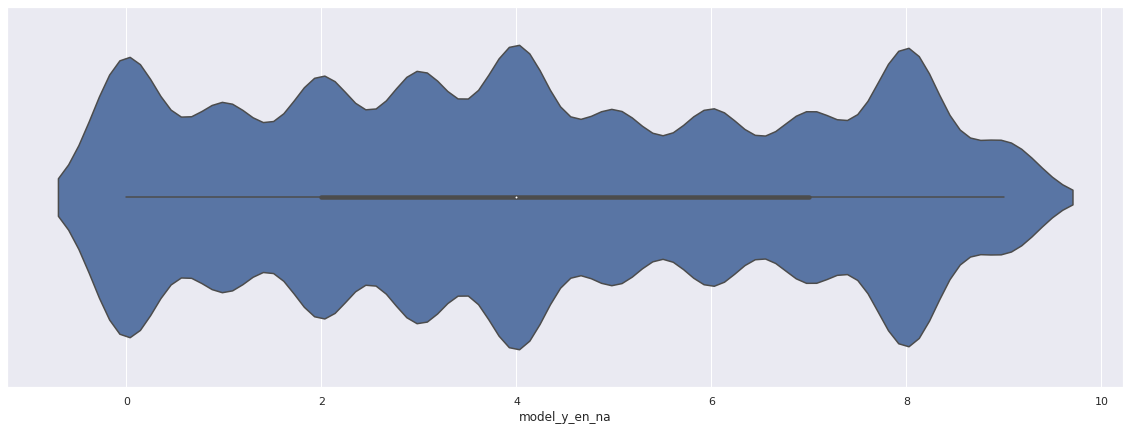

In [82]:
sns.violinplot(x="model_y_en_na", data=vehicle_temp)

#### I guess both mean and median should be ok in this case.  I will use model, price and condition to replace the model_year NaNs.

In [83]:
pivot_modely = vehicle_temp.pivot_table(index =  [ "odo_en",  "price_cat" ], 
                   columns = 'condition_en', values = 'model_y_en_na', 
                   aggfunc = "median")
pivot_modely

condition_en        0    1    2    3    4    5
odo_en price_cat                              
0      0          3.5  0.0  0.0  8.0  4.5  NaN
       1          NaN  0.0  1.5  2.0  4.0  NaN
       2          9.0  2.0  1.0  3.0  4.0  NaN
       3          8.0  0.0  2.0  4.0  6.0  NaN
       4          NaN  7.0  4.0  6.0  8.0  NaN
...               ...  ...  ...  ...  ...  ...
9      5          NaN  3.0  3.0  3.0  4.0  NaN
       6          NaN  NaN  4.0  3.0  3.0  3.0
       7          NaN  NaN  3.0  3.0  3.0  NaN
       8          NaN  NaN  4.0  4.0  4.0  NaN
       9          NaN  NaN  6.0  6.0  6.5  NaN

[100 rows x 6 columns]

In [84]:
def replace_na(row): 
    condition = row["condition_en"] 
    odo = row["odo_en"] 
    price = row['price_cat']

    if pd.isnull(row['model_y_en_na']):
        return pivot_modely[condition][odo][price]
    else: 
        return row['model_y_en_na']


vehicle_temp["model_y_en"] = vehicle_temp.apply(replace_na, axis=1)
vehicle

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,price,model_year,model,condition,cylinders,fuel,odometer,transmission,type,paint_color,is_4wd,date_posted,days_listed
0,9400,2011.0,bmw x5,good,6.0,gas,145000.0,automatic,SUV,NaN,1.0,2018-06-23,19
1,25500,NaN,ford f-150,good,6.0,gas,88705.0,automatic,pickup,white,1.0,2018-10-19,50
2,5500,2013.0,hyundai sonata,like new,4.0,gas,110000.0,automatic,sedan,red,NaN,2019-02-07,79
3,1500,2003.0,ford f-150,fair,8.0,gas,NaN,automatic,pickup,NaN,NaN,2019-03-22,9
4,14900,2017.0,chrysler 200,excellent,4.0,gas,80903.0,automatic,sedan,black,NaN,2019-04-02,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51520,9249,2013.0,nissan maxima,like new,6.0,gas,88136.0,automatic,sedan,black,NaN,2018-10-03,37
51521,2700,2002.0,honda civic,salvage,4.0,gas,181500.0,automatic,sedan,white,NaN,2018-11-14,22
51522,3950,2009.0,hyundai sonata,excellent,4.0,gas,128000.0,automatic,sedan,blue,NaN,2018-11-15,32
51523,7455,2013.0,toyota corolla,good,4.0,gas,139573.0,automatic,sedan,black,NaN,2018-07-02,71


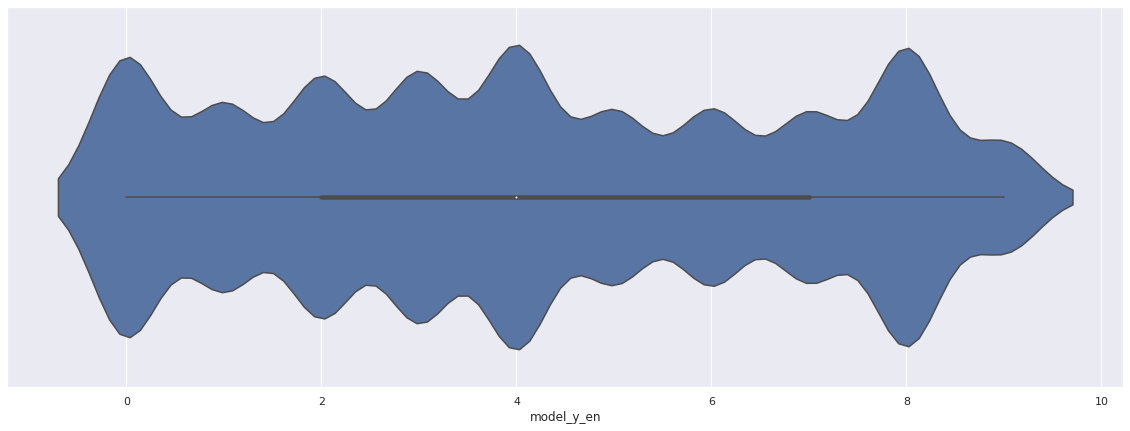

In [85]:
sns.violinplot(x="model_y_en", data=vehicle_temp)

In [86]:
vehicle_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32862 entries, 0 to 51523
Data columns (total 23 columns):
price              32862 non-null int64
model_year         32862 non-null float64
cylinders          32862 non-null float64
odometer           32862 non-null float64
paint_color        27000 non-null object
date_posted        32862 non-null datetime64[ns]
days_listed        32862 non-null int64
is_4wd_en          32862 non-null int64
transmission_en    32862 non-null int64
condition_en       32862 non-null int64
fuel_en            32862 non-null int64
type_en            32862 non-null int64
model_temp         32862 non-null object
model_en           32862 non-null int64
price_cat          32862 non-null int64
color_en_na        27000 non-null float64
color_en           32862 non-null int64
odo_en_na          32862 non-null int64
odo_en             32862 non-null int64
cylinders_en_na    32862 non-null int64
cylinders_en       32862 non-null int64
model_y_en_na      32862 non-nul

We started with a dataframe of 51k and the preprocessing reduced it into 32k.  

### Create the final dataframe to answer the questions

In [87]:
vehicle_final = vehicle_temp[['price', 'model_y_en',"days_listed", "is_4wd_en",  "transmission_en", "condition_en", 
                              "color_en", "odo_en", "cylinders_en", "model_en", "fuel_en", "type_en"
                             ]].copy()

In [88]:
vehicle_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32862 entries, 0 to 51523
Data columns (total 12 columns):
price              32862 non-null int64
model_y_en         32862 non-null int64
days_listed        32862 non-null int64
is_4wd_en          32862 non-null int64
transmission_en    32862 non-null int64
condition_en       32862 non-null int64
color_en           32862 non-null int64
odo_en             32862 non-null int64
cylinders_en       32862 non-null int64
model_en           32862 non-null int64
fuel_en            32862 non-null int64
type_en            32862 non-null int64
dtypes: int64(12)
memory usage: 3.3 MB


In [89]:
column_name_before_int = ["price", "days_listed"]
column_name_after_int = ["price", "days_listed" ]
column_name_before_fo = [ "model_year" , 'is_4wd',  'transmission', 'condition', 
            "paint_color",  "odometer", "cylinders","model", "fuel","type"   ]
column_name_after_fo_to_int = [ "model_y_en" , 'is_4wd_en', 'transmission_en', 'condition_en', 
            "color_en",  "odo_en",  "cylinders_en","model_en", "fuel_en","type_en" ]

In [90]:
def before_after_unchanged_int(column_name_before, column_name_after):
    
    vehicle[column_name_before].hist(
    bins=200, figsize=(12, 5), alpha=.5, density=False
)
    vehicle_final[column_name_after].hist(
    bins=200, figsize=(12, 5), alpha=.5, density=False
)
     
#    beautify_column_name = column_name[0].upper() + column_name[1:].replace('_', ' ')
    # relevent_experience -> Relevent experience
    plt.title('Before and after')
    plt.ylabel('Frequency')
    plt.xlabel("original " + column_name_before + " vs. " +  "preprocessed " + column_name_after)
    plt.legend(['original with nan', 'after preproc'])

    plt.show()

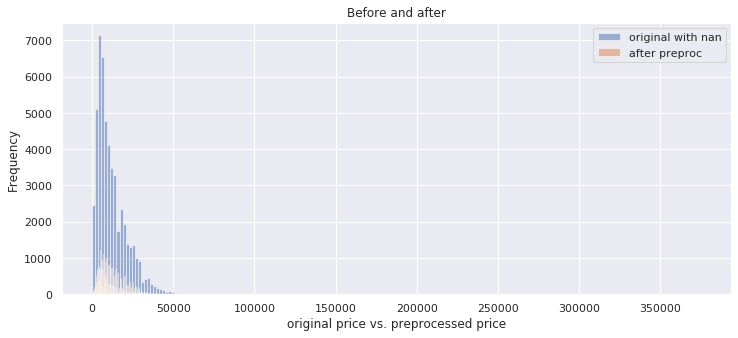

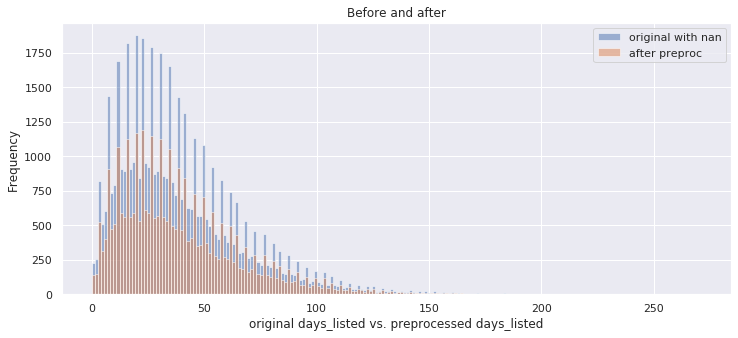

In [91]:
for i in range(0, len(column_name_before_int)):
    before_after_unchanged_int(column_name_before_int[i], column_name_after_int[i])

The distribution of price has changed significantly. The outlier values have decreased.  In addition, the frequency of the ads as similar prices has dropped dramatically.  The distribution is not normal; it is still skewed towards more expensive cars.  It is noteworthy to mention that  extreme values in price and the fact that the unprocessed and preprocessed variables are on the same graph make the graph look empty.  That is because the bins are larger and thus contain more values.   The days listed variable is still skewed towards longer ad ages, but it looks more normalish that the price distribution. 

In [92]:
def before_after_changed_fo(column_name_before, column_name_after):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(25,5))

    
    #plt.subplot(1,2,1)  # row 1, column 2, count 1
    bar_data = vehicle[column_name_before].value_counts(normalize=True)

    bar_data.plot.bar( figsize=(12, 5), rot=90, alpha=.5,fontsize=8, ax=ax1)
    
    
    plt.title('Before')
    plt.xlabel(column_name_before_fo[i])
    plt.ylabel('Frequency')
    plt.legend(['original with nan'])
    
    #plt.subplot(1,2, 2) # row 1, column 2, count 2
    vehicle_final[column_name_after].hist(bins=20, figsize=(12, 5), alpha=.5, density=True, ax=ax2)
    plt.title('After')
    plt.xlabel(column_name_after_fo_to_int[i])
    plt.ylabel('y-axis')
    plt.legend(['after preproc'])
    
    beautify_column_name_before = column_name_before[0].upper() + column_name_before[1:].replace('_', ' ')
    
    fig.suptitle(f' {beautify_column_name_before}', fontsize=18)

    #fig.suptitle('Before and after' + " column_name_before_fo[i]")
    #plt.title('Before and after')
    #plt.ylabel('Frequency')
    #plt.xlabel(column_name_before_fo + " vs. " + column_name_after_fo_to_int)
   # plt.legend(['original with nan', 'after preproc'])

    plt.show()

In [ ]:
for i in range(0, len(column_name_before_fo)):
    before_after_changed_fo(column_name_before_fo[i], column_name_after_fo_to_int[i])

### The variables in these plots were transformed.  Model year had to be categorized in order to replace NaN. Its new distribution is not bell shaped, it is rather multi-modal.  The is_4wd makes sense.  Four wheel and non four wheel create a dichotomous variable of almost equal size.  The transmission variable did not change much.  Neither did the condition variable although as I mentioned twice before, its encoding changes.  But still excellent and good are the most frequent categories.  The odometer variable had to be categorized because of replace NaNs.  Its current distribution is acceptable.  Fuel type has not changed much.  Some car models, mainly American cars such as ford and chevy are the most frequent in the dataset.  The cylinder variable did not change much after preprocessing

# 7 Answer sprint questions

### 7a- days_listed: Study how many days advertisements were displayed (days_listed). Plot a histogram. Calculate the mean and median. Describe the typical lifetime of an ad. Determine when ads were removed quickly, and when they were listed for an abnormally long time.

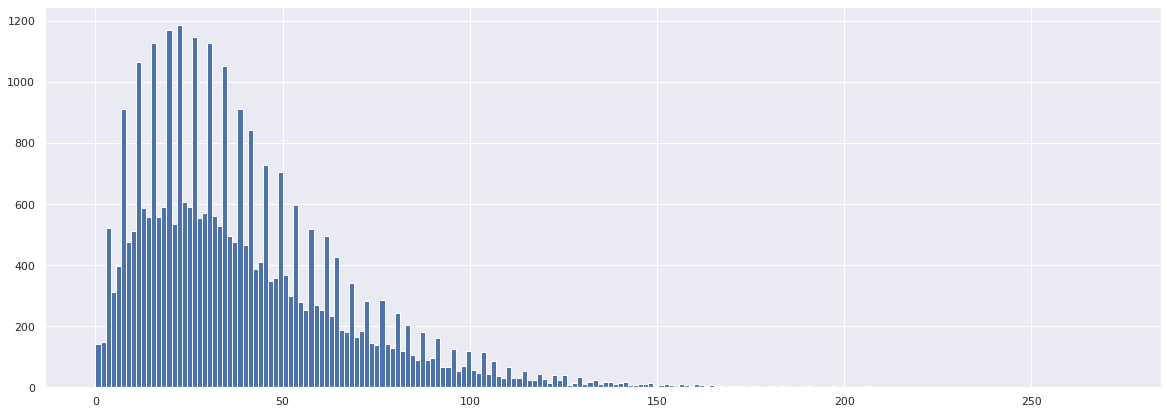

In [94]:
vehicle_final.days_listed.hist(bins = 200)

The distribution is skewed towards longer days listed.  We should expect the mean to be higher than the median.

In [95]:
vehicle_final.days_listed.mean()

39.710881869636665

In [96]:
vehicle_final.days_listed.median()

33.0

### The definition of abnormal is outside 3 standard deviations from the mean.  

In [97]:
q_low = vehicle_final["days_listed"].quantile(0.01)
q_hi  = vehicle_final["days_listed"].quantile(0.99)
print(q_low, q_hi)

3.0 132.0


The typical timeline of an ad is between 3 standard deviation of the mean of 40 days, roughly between 3 and 132 days.

In [98]:
vehicle_ab_ads = vehicle_final[(vehicle_final["days_listed"] >= q_hi) | (vehicle_final["days_listed"] <= q_low)]

vehicle_ab_ads.shape

(887, 12)

882 ads do not fall within this bracket and are considered abnomrally short or long ads.

### I create scatter plots to visualize if there is any replationship between ad lifetime and another variable

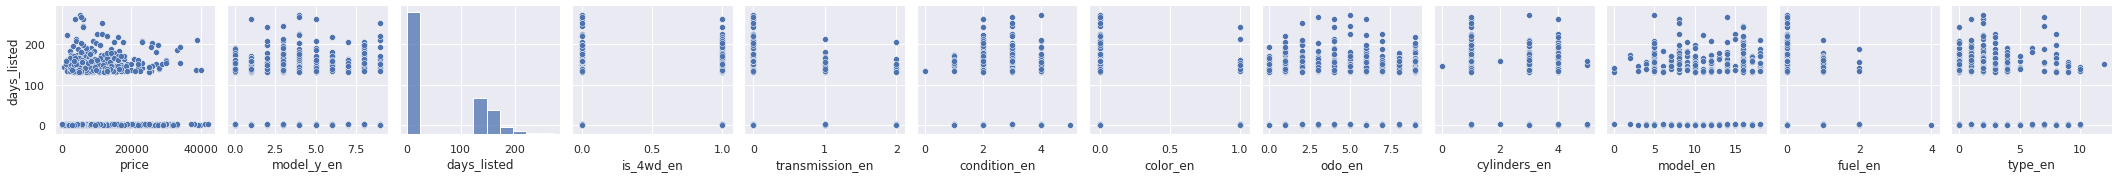

In [99]:
sns.pairplot(vehicle_ab_ads, y_vars="days_listed", x_vars=vehicle_ab_ads.columns.values);

### There does not seem to be a specific variable that explains ad lifetime.  Values for each variable exist in this extreme dataframe.

### 7b- Analyze the number of ads and the average price for each type of vehicle. Plot a graph showing the dependence of the number of ads on the vehicle type. Select the two types with the greatest number of ads.

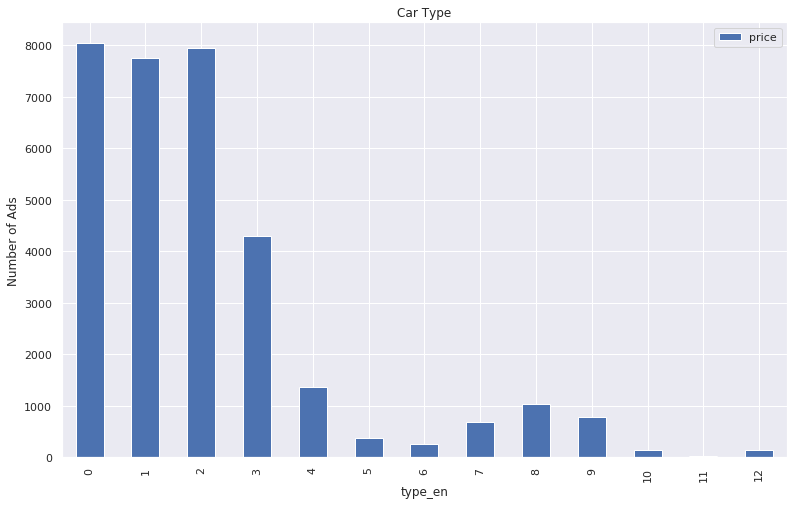

In [100]:
vehicle_final.groupby('type_en').agg({'price': 'count'}).plot(
    kind='bar', figsize=(13, 8)
)
plt.title("Car Type")
plt.ylabel('Number of Ads')
plt.show()

In [101]:
vehicle_final['type_en'].value_counts()/len(vehicle_final['type_en'])*100

0     24.481164
2     24.176861
1     23.626073
3     13.094151
4      4.141562
8      3.143448
9      2.397906
7      2.057087
5      1.156351
6      0.775972
12     0.456454
10     0.435153
11     0.057818
Name: type_en, dtype: float64

### Let's do a correlation matrix to understand the strength of association between variables

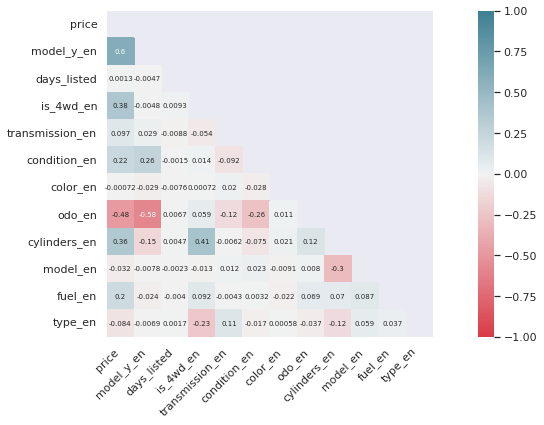

In [102]:

plt.figure(figsize=(16, 6))


corr = vehicle_final.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(10, 220,  as_cmap=True),
    square=True,
    mask=mask,
    annot=True,
    annot_kws={"size": 7}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);


The most important relationships are between model_year and price & model_year and odometer & odometer and price.  Some are postively correlated and others are negatively correlated.

### I now run a correlation model using all the variables as predictors and price as a dependent variable

In [103]:
model1 = ols('price ~  odo_en + condition_en + model_y_en + transmission_en + color_en', data=vehicle_final)
results = model1.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.387
Method:                 Least Squares   F-statistic:                     4153.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:43:46   Log-Likelihood:            -3.3447e+05
No. Observations:               32862   AIC:                         6.689e+05
Df Residuals:                   32856   BIC:                         6.690e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        6403.1318    194.300     32.955      0.000    6022.296    6783.967
odo_en           -536.1867     16.106    -33.292      0.000    -567.754    -504.619
condition_en      646.8694     53.232     12.152      0.000     542.533     751.206
model_y_en       1373.5845     15.488     88.690      0.000    1343.228    1403.941
transmission_en  1441.9002     95.582     15.085      0.000    1254.555    1629.245
color_en          681.1103    195.734      3.480      0.001     297.464    1064.756
==============================================================================
Omnibus:                     3533.331   Durbin-Watson:                   1.718
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5407.967
Skew:                           0.797   Prob(JB):                         0.00
Kurtosis:                       4.187   Cond. No.                         41.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Based on the p-value, all variables are important in helping estimate price in this specific dataset. 
- Unsurprisingly, mileage has a negative effect on price.  As the mileage increases (more accurately its category does), the price of a car on average decreases if we keep everything else constant.   
- Type has no order and hence its estimate is meaningless.	Yet it does explain price as we will see when we compare SUV and sedans below.
- Four wheel drive cars, on average and holding everything else constant, are around \\$3800 more expensive than non four wheel drives.
- As the car engine cylinder increases, the price of a car, on average and holding everything else constant, increase by around \\$2400.
- As we move from one category of odometer to another, the cost of a car, on average and holding everything else constant,  decreases by around \\$690.
- As the condition of a car improves from one category to another, its price, on average and holding everything else constant, increases by around \\$685.
- Although older car in good condition can be more expensive than newer model cars, on average and holding everything else constant, as the age of a car decreases from one category to another, its price increase around \\$1460.	 
- All other variables held constant, as we move from automatic to manual transmission, the cost of a car increases by around \\$1600.
- All things constant, as we move from gas to diesel, then hybrid, the cost of a car increases by around \\$4200.
- But as we move from common to uncommon car colors the price of a car decreases, holding everything else constant.  This also makes sense.  Its magnitude is important almost \\$550.

### Top two car types with the most ads

Type 0 and type 2 are, according to my encoding scheme, the vehicles with the most ads. Respectively, they refer to SUVs and sedans.Trucks is now third instead of second in this specific dataset, but still hovering around the 24% figure of total cars.  SUV is at 8045 after preprocessing from 12405; sedan is at 7945 from 12154 and trucks are at 7764 from 12353.

## 7-b Create a dataframe for SUV and repeat the correlation matrix and regression model

In [104]:
SUV_df = vehicle_final.loc[(vehicle_final['type_en'] == 0)]
SUV_df.head()

,price,model_y_en,days_listed,is_4wd_en,transmission_en,condition_en,color_en,odo_en,cylinders_en,model_en,fuel_en,type_en
0,9400,4,19,1,0,2,0,6,3,2,0,0
7,15990,6,68,1,0,3,0,4,3,10,0,0
8,11500,5,19,1,0,3,0,4,1,13,0,0
14,12990,3,24,1,0,3,0,6,4,9,0,0
17,13990,7,25,1,0,3,0,4,3,12,0,0


### Correlation matrix

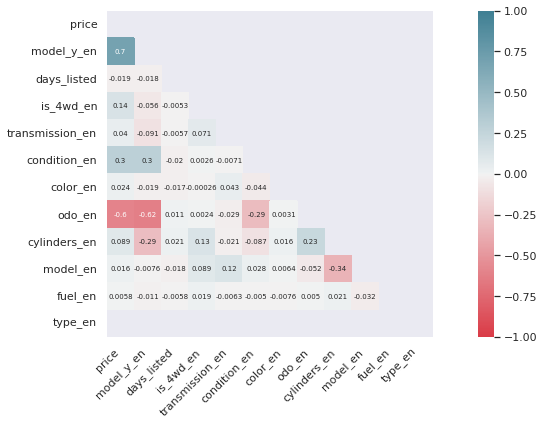

In [105]:
corr = SUV_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

plt.figure(figsize=(16, 6))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(10, 220,  as_cmap=True),
    square=True,
    mask=mask,
    annot=True,
    annot_kws={"size": 7}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);



The most important relationships in this matrix are between price and odometer & price and model_year & odometer and model_year.  Some are positively correlated and others are negatively correlated.

### Scatter Plots

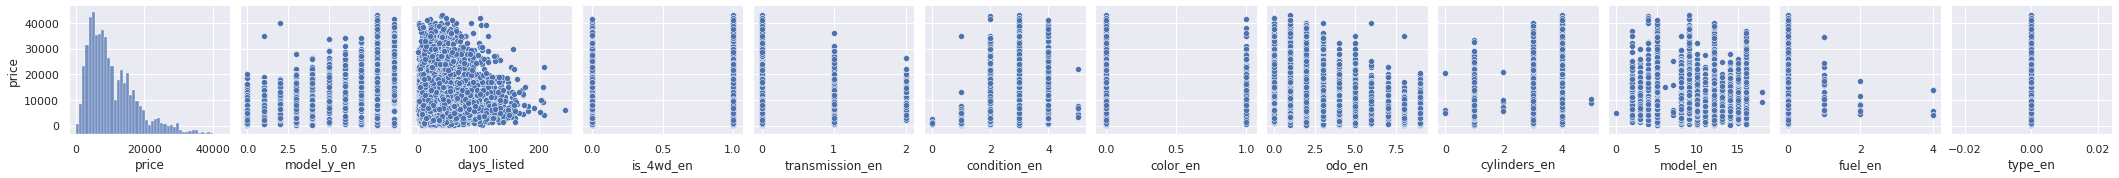

In [106]:
sns.pairplot(SUV_df, y_vars="price", x_vars=SUV_df.columns.values);

### Now regression model with SUV only

In [107]:
model_SUV = ols("price ~  odo_en + condition_en + model_y_en + transmission_en + color_en", data = SUV_df)
results_SUV = model_SUV.fit()
results_SUV.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     1904.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:44:01   Log-Likelihood:                -79745.
No. Observations:                8045   AIC:                         1.595e+05
Df Residuals:                    8039   BIC:                         1.595e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        6428.2032    317.636     20.238      0.000    5805.554    7050.852
odo_en           -685.5615     26.402    -25.966      0.000    -737.317    -633.806
condition_en      731.3324     85.040      8.600      0.000     564.633     898.032
model_y_en       1374.4456     25.679     53.524      0.000    1324.108    1424.783
transmission_en  2186.9642    209.003     10.464      0.000    1777.265    2596.663
color_en         1289.5446    283.470      4.549      0.000     733.870    1845.219
==============================================================================
Omnibus:                     1068.011   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3216.429
Skew:                           0.700   Prob(JB):                         0.00
Kurtosis:                       5.763   Cond. No.                         43.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Again the p_values for all coefficients are at 0.  So all these variables affect the price of an SUV.
- Only odometer here moves in the opposite direction of price. As the mileage of SUVs moves from one category to another, their prices, on average and holding everything else constant, decrease by around \\$690. 
- Similarly as the condition of SUV improves from one category to another, their price, on average and holding everything else constant, increases by \\$730. 
- As the model year of an SUV becomes more recent its price, on average and holding everything else constant, increases by \\$1370.  
- Manual SUV are, on average and holding everything else constant, \\$2190 more expensive than automatic SUVs.  
- And common color SUVs are, on average and holding everything else constant, around 1300 more expensive than uncommon color SUVs.

## 7-c Create a dataframe for sedans and repeat the correlation matrix and regression model

### Create a dataset for sedans and repeat the correlation matrix and regression model

In [108]:
sedan_df = vehicle_final.loc[(vehicle_final['type_en'] == 2)]
sedan_df.head()

,price,model_y_en,days_listed,is_4wd_en,transmission_en,condition_en,color_en,odo_en,cylinders_en,model_en,fuel_en,type_en
2,5500,6,79,0,0,4,0,4,1,11,0,2
4,14900,9,28,0,0,3,0,3,1,6,0,2
5,14990,7,15,1,0,3,0,1,3,6,0,2
6,12990,8,73,0,0,3,0,2,1,16,0,2
11,8990,5,29,0,0,3,0,4,1,10,0,2


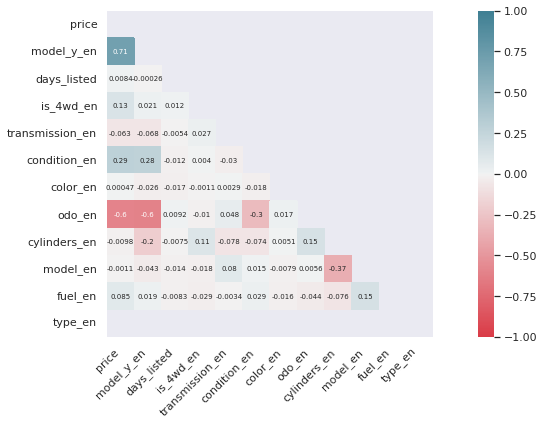

In [109]:
corr = sedan_df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)]= True

plt.figure(figsize=(16, 6))

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(10, 220,  as_cmap=True),
    square=True,
    mask=mask,
    annot=True,
    annot_kws={"size": 7}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);



The most important relationships in this matrix are between price and odometer & price and model_year & odometer and model_year.  Some are positively correlated and others are negatively correlated.

### Scatter plots for this dataframe

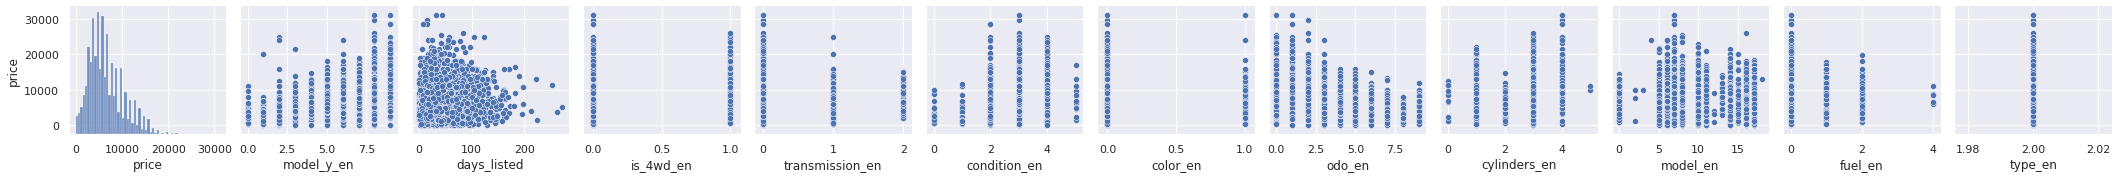

In [110]:
sns.pairplot(sedan_df, y_vars="price", x_vars=sedan_df.columns.values);

### Regression model for this dataframe

In [111]:
model_sedan_df = ols("price ~  odo_en + condition_en + model_y_en + transmission_en + color_en", data=sedan_df)
results_sedan_df = model_sedan_df.fit()
results_sedan_df.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     1952.
Date:                Thu, 24 Feb 2022   Prob (F-statistic):               0.00
Time:                        12:44:19   Log-Likelihood:                -73693.
No. Observations:                7945   AIC:                         1.474e+05
Df Residuals:                    7939   BIC:                         1.474e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        4037.7291    164.173     24.594      0.000    3715.907    4359.551
odo_en           -382.7473     14.040    -27.261      0.000    -410.269    -355.225
condition_en      326.0494     43.207      7.546      0.000     241.353     410.746
model_y_en        773.6108     13.790     56.099      0.000     746.579     800.643
transmission_en  -183.4202    108.662     -1.688      0.091    -396.426      29.586
color_en          488.0173    181.583      2.688      0.007     132.067     843.968
==============================================================================
Omnibus:                     1168.782   Durbin-Watson:                   1.783
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10799.054
Skew:                           0.410   Prob(JB):                         0.00
Kurtosis:                       8.652   Cond. No.                         44.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Again the p_values for all coefficients are at 0.  So all these variables affect the price of an SUV.  Here too all the variables have an effect on price.  But both transmission and and odometer have a negative effect on price.  
- As the mileage of sedans moves from one category to another, their prices, on average and holding everything else constant, decrease by around \\$380 much less than that of SUV.  
- As the model year of an sedan becomes more recent its price, on average and holding everything else constant, increases by \\$770, much less than SUVs.  
- Similarly as the condition of a sedan improves from one category to another, their price, on average and holding everything else constant, increases by \\$325, much less than SUV. 
- Unlike SUVs, automatic sedans are, on average and holding everything else constant, more expensive than manual sedan. 
- Like SUVs and other cars in the dataset, common color sedans are, on average and holding everything else constant, more expensive than uncommon sedans, but the magnitude is around \\$490. 

### In the table below, I copy the estimators from the regression tables to visualize them and conclude

In [112]:
table = [[" ", "odometer", "condition", "model_year", "transmission", "color"], 
         ["all", -536.1867, 646.8694, 1373.5845, 1441.9002, 681.1103],  
         ["SUV",-685.5615, 731.3324, 1374.4456, 2186.9642, 1289.5446],
         ["sedan",-382.7473, 326.0494, 773.6108, 183.4202, 488.0173]
        ]


print(tabulate(table))

-----  ---------  ---------  ----------  ------------  ---------
       odometer   condition  model_year  transmission  color
all    -536.1867  646.8694   1373.5845   1441.9002     681.1103
SUV    -685.5615  731.3324   1374.4456   2186.9642     1289.5446
sedan  -382.7473  326.0494   773.6108    183.4202      488.0173
-----  ---------  ---------  ----------  ------------  ---------


Since the same regression model was used for the 3 different dataset, I can make some conclusions.:
- Sedans lose less value than SUVs do as they accumulate mileage.  In fact, they seem to be some of the least cars in the dataset to loose value as their odometers accumulate mileage. 
- But as they maintain their condition, SUVs maintain more value than sedans.  This trend makes more sense because newer SUVs are usually more expensive than newer sedans which probably stems from the original price tag of an SUV.   SUVs in good condition are more expensive than the average car in the dataset.
- As the model year of a car increases and car become newer, its value increases, but SUVs do that better than sedans, although in line with the rest of the cars in the dataset.
- In terms of transmission, SUVs become more expensive than most cars as their transmission moves from automatic to manual.  
- For all cars, common colors are more appealing.  But common colors are the most valuable for SUVs.


In sum, ads for newer, manual, common colors and well maintained SUVs show the highest price tags. 